# Imports

In [4]:
import pandas as pd
import numpy as np

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pylab as plt

In [6]:
from statsmodels.tsa.arima_model import ARMA

In [7]:
from sklearn.metrics import mean_squared_error as mse

In [8]:
import warnings
warnings.simplefilter('ignore')

In [9]:
plt.rcParams['figure.figsize']=(20, 20)

# Functions

## Data cleaning

In [10]:
def clean_data():
    
    global db1
    db1 = db1[(db1.num_infections > 0)].reset_index()
    db1 = db1.drop(columns = ['index'], axis = 1)
    
    db1['date'] = pd.to_datetime(db1.date)
    
   
    db1['autonomous_region'] = db1.autonomous_region.apply(lambda x: 'Comunidad Valenciana' if x == 'Valenciana, Comunidad' else x)
    db1['autonomous_region'] = db1.autonomous_region.apply(lambda x: 'Comunidad de Madrid' if x == 'Madrid, Comunidad de' else x)
    db1['autonomous_region'] = db1.autonomous_region.apply(lambda x: 'Región de de Murcia' if x == 'Murcia, Región de' else x)
    db1['autonomous_region'] = db1.autonomous_region.apply(lambda x: 'Comunidad Foral de Navarra' if x == 'Navarra, Comunidad Foral de' else x)
    db1['autonomous_region'] = db1.autonomous_region.apply(lambda x: 'Principado de Asturias' if x == 'Asturias, Principado de' else x)
    
    
    db1['province'] = db1.province.apply(lambda x: 'Alicante' if x == 'Alicante/Alacant' else x)
    db1['province'] = db1.province.apply(lambda x: 'Castellón' if x == 'Castellón/Castelló' else x)
    db1['province'] = db1.province.apply(lambda x: 'Araba' if x == 'Araba/Álava' else x)
    db1['province'] = db1.province.apply(lambda x: 'Valencia' if x == 'Valencia/València' else x)
    
    db1['sex'] = db1.sex.apply(lambda x: 'UKNOWN' if x == 'NC' else x)
    
    db1['age_interval'] = db1.age_interval.apply(lambda x: 'UKNOWN' if x == 'NC' else x)

## Cumulative

In [11]:
def cumulative(dataframe):
    
    cumu_num_infections = dataframe.num_infections.cumsum()
    cumu_num_hosp = dataframe.num_hosp.cumsum()
    cumu_num_uci = dataframe.num_uci.cumsum()
    cumu_num_dead = dataframe.num_dead.cumsum()

    cumulative = pd.DataFrame({'cumu_num_infections': cumu_num_infections, 'cumu_num_hosp': cumu_num_hosp, 
                               'cumu_num_uci': cumu_num_uci, 'cumu_num_dead': cumu_num_dead})
    dataframe = pd.concat([dataframe, cumulative], axis = 1)
    return dataframe

## Relative frequencies

In [12]:
def freq_rel(dataframe):
    
    dataframe['Number of infection (%)'] = [round(i/ dataframe['num_infections'].sum(),3)*100 for i in dataframe['num_infections']]
    dataframe['Number of hospitalisation (%)'] = [round(i/ dataframe['num_hosp'].sum(),3)*100 for i in dataframe['num_hosp']]
    dataframe['Number of Intensive Care Unit (%)'] = [round(i/ dataframe['num_uci'].sum(),3)*100 for i in dataframe['num_uci']]
    dataframe['Number of deaths (%)'] = [round(i/ dataframe['num_dead'].sum(),3)*100 for i in dataframe['num_dead']]

In [13]:
def organise(column):
    
    name = db1.groupby(column).sum()
    freq_rel(name)
    
    return name

## Moving averages: 7 days moving average

In [14]:
def mov_7_ave(dataframe):
    dataframe['ave_7_num_infections'] = dataframe.iloc[:,1].rolling(window=7).mean()
    dataframe['ave_7_num_hosp'] = dataframe.iloc[:,2].rolling(window=7).mean()
    dataframe['ave_7_num_uci'] = dataframe.iloc[:,3].rolling(window=7).mean()
    dataframe['ave_7_num_dead'] = dataframe.iloc[:,4].rolling(window=7).mean()
    
    return dataframe

## Evolution

In [15]:
def evolution(dataframe):
    global db1
    
    bydate = db1.groupby('date').sum().reset_index()
    bydate = cumulative(bydate)
    bydate = mov_7_ave(bydate)
    
    return bydate

# Data

In [16]:
db1 =pd.read_csv('covid-19-sample.csv')

In [17]:
db1

,date,autonomous_region,province,sex,age_interval,num_infections,num_hosp,num_uci,num_dead
0,2020-01-01,"Valenciana, Comunidad",Alicante/Alacant,H,0-9,0,0,0,0
1,2020-01-01,"Valenciana, Comunidad",Alicante/Alacant,H,10-19,0,0,0,0
2,2020-01-01,"Valenciana, Comunidad",Alicante/Alacant,H,20-29,0,0,0,0
3,2020-01-01,"Valenciana, Comunidad",Alicante/Alacant,H,30-39,0,0,0,0
4,2020-01-01,"Valenciana, Comunidad",Alicante/Alacant,H,40-49,0,0,0,0
...,...,...,...,...,...,...,...,...,...
822115,2021-06-10,Castilla y León,Zamora,NC,50-59,0,0,0,0
822116,2021-06-10,Castilla y León,Zamora,NC,60-69,0,0,0,0
822117,2021-06-10,Castilla y León,Zamora,NC,70-79,0,0,0,0
822118,2021-06-10,Castilla y León,Zamora,NC,80+,0,0,0,0


In [18]:
clean_data()

In [19]:
bydate = evolution(db1)

In [36]:
def predict(name, days):
    
    global bydate
    
    if name == 'Number of infections':
        
        infections = bydate[['date', 'ave_7_num_infections']].set_index('date')
        infections = infections[6:]
        train, test = infections[:-days], infections[-days:]
        
        if days == 1:
            
            model=ARMA(train, order = (4, 2)).fit(disp=False)
            print('rsme:', mse(model.predict(len(train), len(infections)-1), test)**0.5, 'daily infections')
            return pd.DataFrame(model.predict(), columns = ['pred_num_infections_1'])
        
        if days == 3:
            
            model=ARMA(train, order = (4, 12)).fit(disp=False)
            print('rsme:', mse(model.predict(len(train), len(infections)-1), test)**0.5, 'daily infections')
            return pd.DataFrame(model.predict(), columns = ['pred_num_infections_3'])
            
        if days == 5:
            
            model=ARMA(train, order = (19, 11)).fit(disp=False)
            print('rsme:', mse(model.predict(len(train), len(infections)-1), test)**0.5, 'daily infections')
            return pd.DataFrame(model.predict(), columns = ['pred_num_infections_5'])
        
        if days == 7:
            
            model=ARMA(train, order = (19, 7)).fit(disp=False)
            print('rsme:', mse(model.predict(len(train), len(infections)-1), test)**0.5, 'daily infections')
            return pd.DataFrame(model.predict(), columns = ['pred_num_infections_7'])
        

    if name == 'Number of hospitalisation':
        
        hosp = bydate[['date', 'ave_7_num_hosp']].set_index('date')
        hosp = hosp[6:]
        train, test = hosp[:-days], hosp[-days:]
        
        if days == 1:
            
            model=ARMA(train, order = (2, 2)).fit(disp=False)
            print('rsme:', mse(model.predict(len(train), len(hosp)-1), test)**0.5, 'daily hospitalisations')
            return pd.DataFrame(model.predict(), columns = ['pred_num_hosp_1'])
        
        if days == 3:
            
            model=ARMA(train, order = (6, 5)).fit(disp=False)
            print('rsme:', mse(model.predict(len(train), len(hosp)-1), test)**0.5, 'daily hospitalisations')
            return pd.DataFrame(model.predict(), columns = ['pred_num_hosp_3'])
            
        if days == 5:
            
            model=ARMA(train, order = (2, 8)).fit(disp=False)
            print('rsme:', mse(model.predict(len(train), len(hosp)-1), test)**0.5, 'daily hospitalisations')
            return pd.DataFrame(model.predict(), columns = ['pred_num_hosp_5'])

        if days == 7:
            
            model=ARMA(train, order = (19, 11)).fit(disp=False)
            print('rsme:', mse(model.predict(len(train), len(hosp)-1), test)**0.5, 'daily hospitalisations')
            return pd.DataFrame(model.predict(), columns = ['pred_num_hosp_7'])

        
    if name == 'Number of Intensive Care Unit':
        
        uci = bydate[['date', 'ave_7_num_uci']].set_index('date')
        uci = uci[6:]
        train, test = uci[:-days], uci[-days:]
        
        if days == 1:
            
            model=ARMA(train, order = (2, 4)).fit(disp=False)
            print('rsme:', mse(model.predict(len(train), len(uci)-1), test)**0.5, 'daily intensive care unit')
            return pd.DataFrame(model.predict(), columns = ['pred_num_uci_1'])
        
        if days == 3:
            
            model=ARMA(train, order = (5, 5)).fit(disp=False)
            print('rsme:', mse(model.predict(len(train), len(uci)-1), test)**0.5, 'daily intensive care unit')
            return pd.DataFrame(model.predict(), columns = ['pred_num_uci_3'])
            
        if days == 5:
            
            model=ARMA(train, order = (4, 5)).fit(disp=False)
            print('rsme:', mse(model.predict(len(train), len(uci)-1), test)**0.5, 'daily intensive care unit')
            return pd.DataFrame(model.predict(), columns = ['pred_num_uci_5'])

        if days == 7:
            
            model=ARMA(train, order = (2, 6)).fit(disp=False)
            print('rsme:', mse(model.predict(len(train), len(uci)-1), test)**0.5, 'daily intensive care unit')
            return pd.DataFrame(model.predict(), columns = ['pred_num_uci_7'])

    if name == 'Number of deaths':
        
        deaths = bydate[['date', 'ave_7_num_dead']].set_index('date')
        deaths = deaths[6:]
        train, test = deaths[:-days], deaths[-days:]
        
        if days == 1:
            
            model=ARMA(train, order = (2, 3)).fit(disp=False)
            print('rsme:', mse(model.predict(len(train), len(deaths)-1), test)**0.5, 'daily deaths')
            return pd.DataFrame(model.predict(), columns = ['pred_num_dead_1'])
        
        if days == 3:
            
            model=ARMA(train, order = (4, 5)).fit(disp=False)
            print('rsme:', mse(model.predict(len(train), len(deaths)-1), test)**0.5, 'daily deaths')
            return pd.DataFrame(model.predict(), columns = ['pred_num_dead_3'])
            
        if days == 5:
            
            model=ARMA(train, order = (9, 6)).fit(disp=False)
            print('rsme:', mse(model.predict(len(train), len(deaths)-1), test)**0.5, 'daily deaths')
            return pd.DataFrame(model.predict(), columns = ['pred_num_dead_5'])

        if days == 7:
            
            model=ARMA(train, order = (2, 7)).fit(disp=False)
            print('rsme:', mse(model.predict(len(train), len(deaths)-1), test)**0.5, 'daily deaths')
            return pd.DataFrame(model.predict(), columns = ['pred_num_dead_7'])


# Number of infections

In [25]:
pred_num_infections_1 = predict('Number of infections', 1)

rsme: 0.8948312256152349 daily infections


In [81]:
def compare_pred(prediction):
    
    
    global bydate, pred_num_infections_1, pred_num_infections_3
    
    if prediction is pred_num_infections_1:
        
        plt.plot(bydate[['date', 'ave_7_num_infections']].set_index('date'), label = '7 days moving average', color = 'Darkgreen', linewidth=10)
        plt.plot(pred_num_infections_1.pred_num_infections_1, label = 'Prediction 1 day', color = 'yellow', linewidth=3)
        plt.legend(fontsize = 'xx-large')
        plt.show();

    if prediction is pred_num_infections_3:
        
        plt.plot(bydate[['date', 'ave_7_num_infections']].set_index('date'), label = '7 days moving average', color = 'Darkgreen', linewidth=10)
        plt.plot(pred_num_infections_3.pred_num_infections_3, label = 'Prediction 3 days', color = 'yellow', linewidth=3)
        plt.legend(fontsize = 'xx-large')
        plt.show();
        
        
    if prediction is pred_num_infections_5:
        
        plt.plot(bydate[['date', 'ave_7_num_infections']].set_index('date'), label = '7 days moving average', color = 'Darkgreen', linewidth=10)
        plt.plot(pred_num_infections_5.pred_num_infections_5, label = 'Prediction 5 days', color = 'yellow', linewidth=3)
        plt.legend(fontsize = 'xx-large')
        plt.show();
            
    if prediction is pred_num_infections_7:
        
        plt.plot(bydate[['date', 'ave_7_num_infections']].set_index('date'), label = '7 days moving average', color = 'Darkgreen', linewidth=10)
        plt.plot(pred_num_infections_7.pred_num_infections_7, label = 'Prediction 7 days', color = 'yellow', linewidth=3)
        plt.legend(fontsize = 'xx-large')
        plt.show();

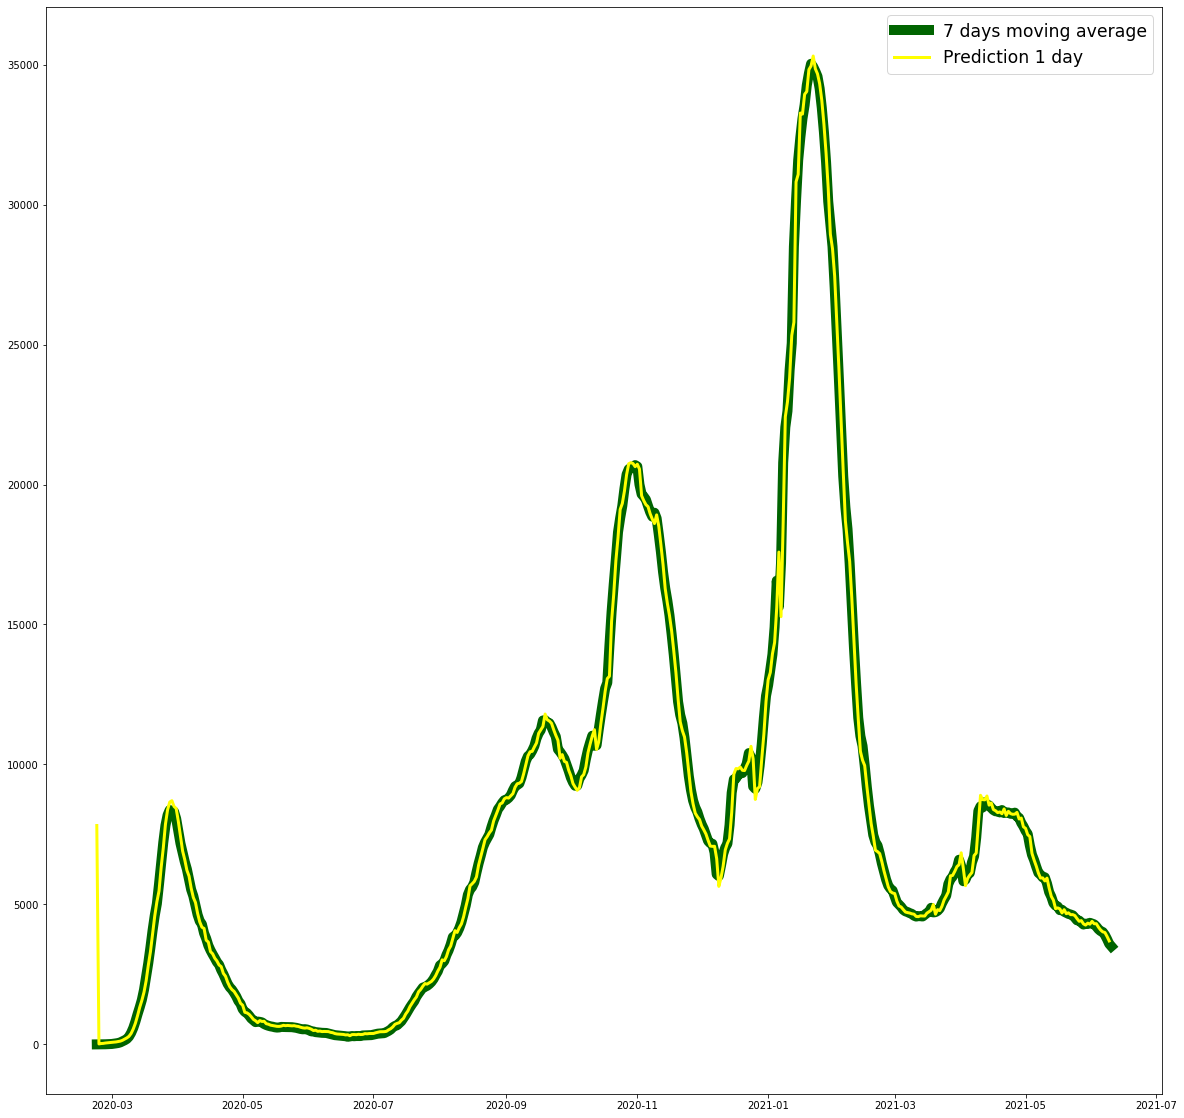

In [82]:
compare_pred(pred_num_infections_1)

In [21]:
pred_num_infections_3 = predict('Number of infections', 3)

rsme: 102.2607415602929 daily infections


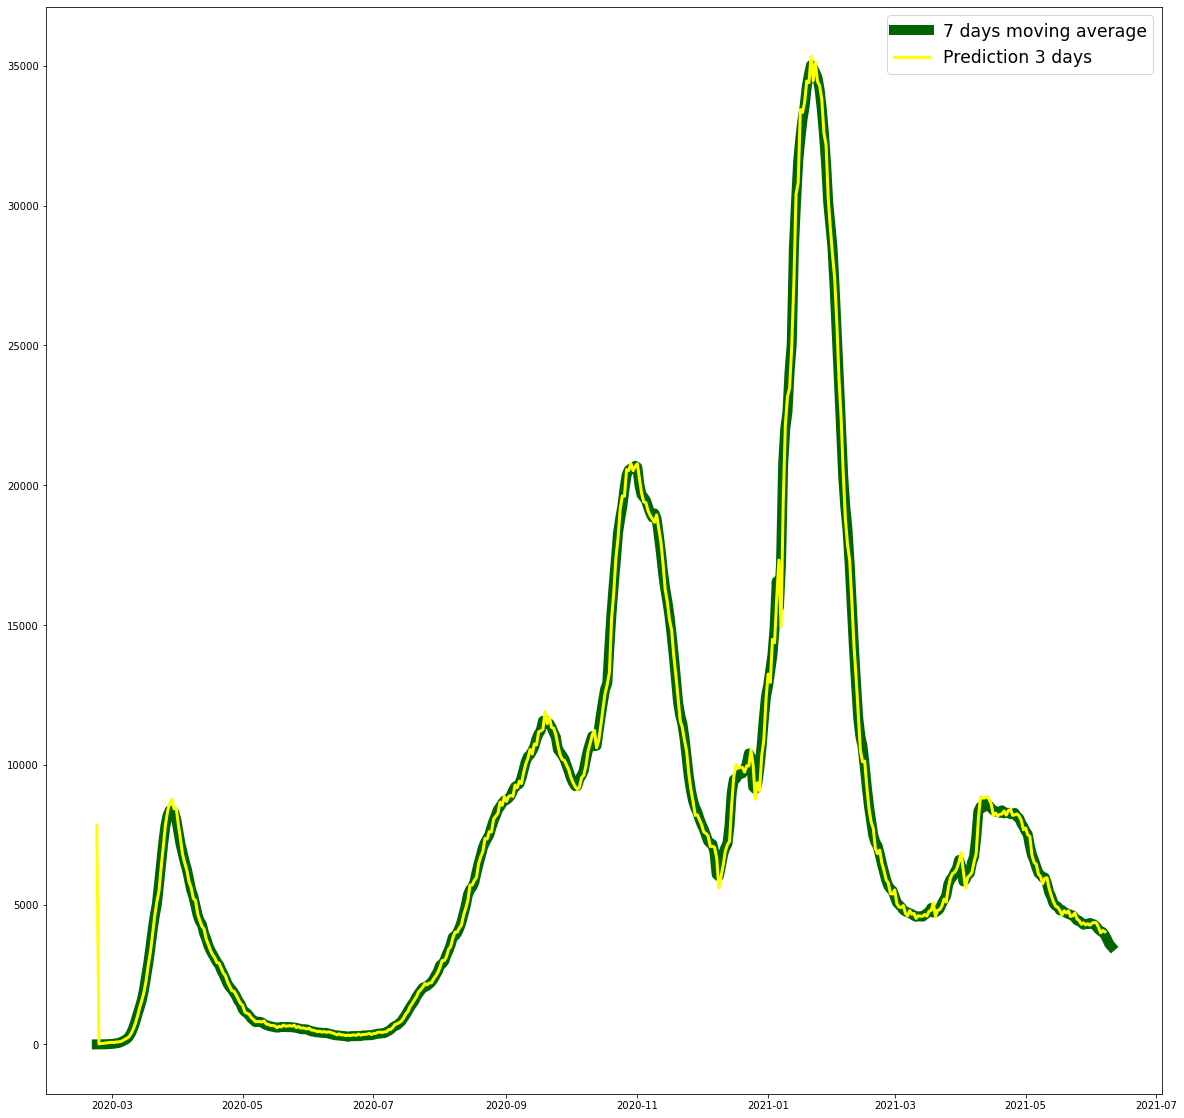

In [83]:
compare_pred(pred_num_infections_3)

In [22]:
pred_num_infections_5 = predict('Number of infections', 5)

rsme: 357.45878260447734 daily infections


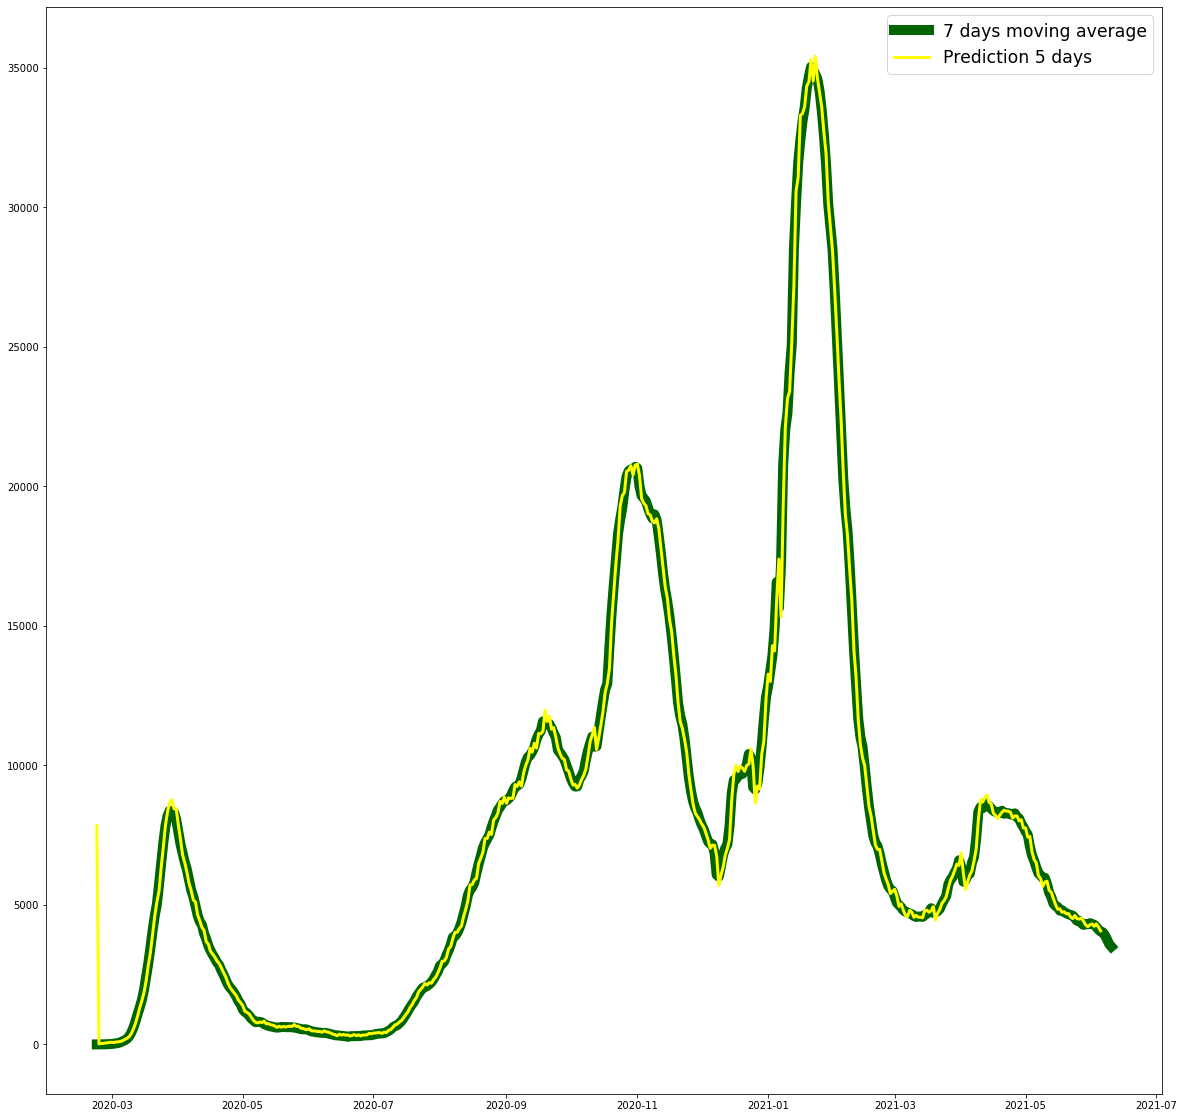

In [84]:
compare_pred(pred_num_infections_5)

In [45]:
pred_num_infections_7 = predict('Number of infections', 7)

rsme: 62.618719214126635 daily infections


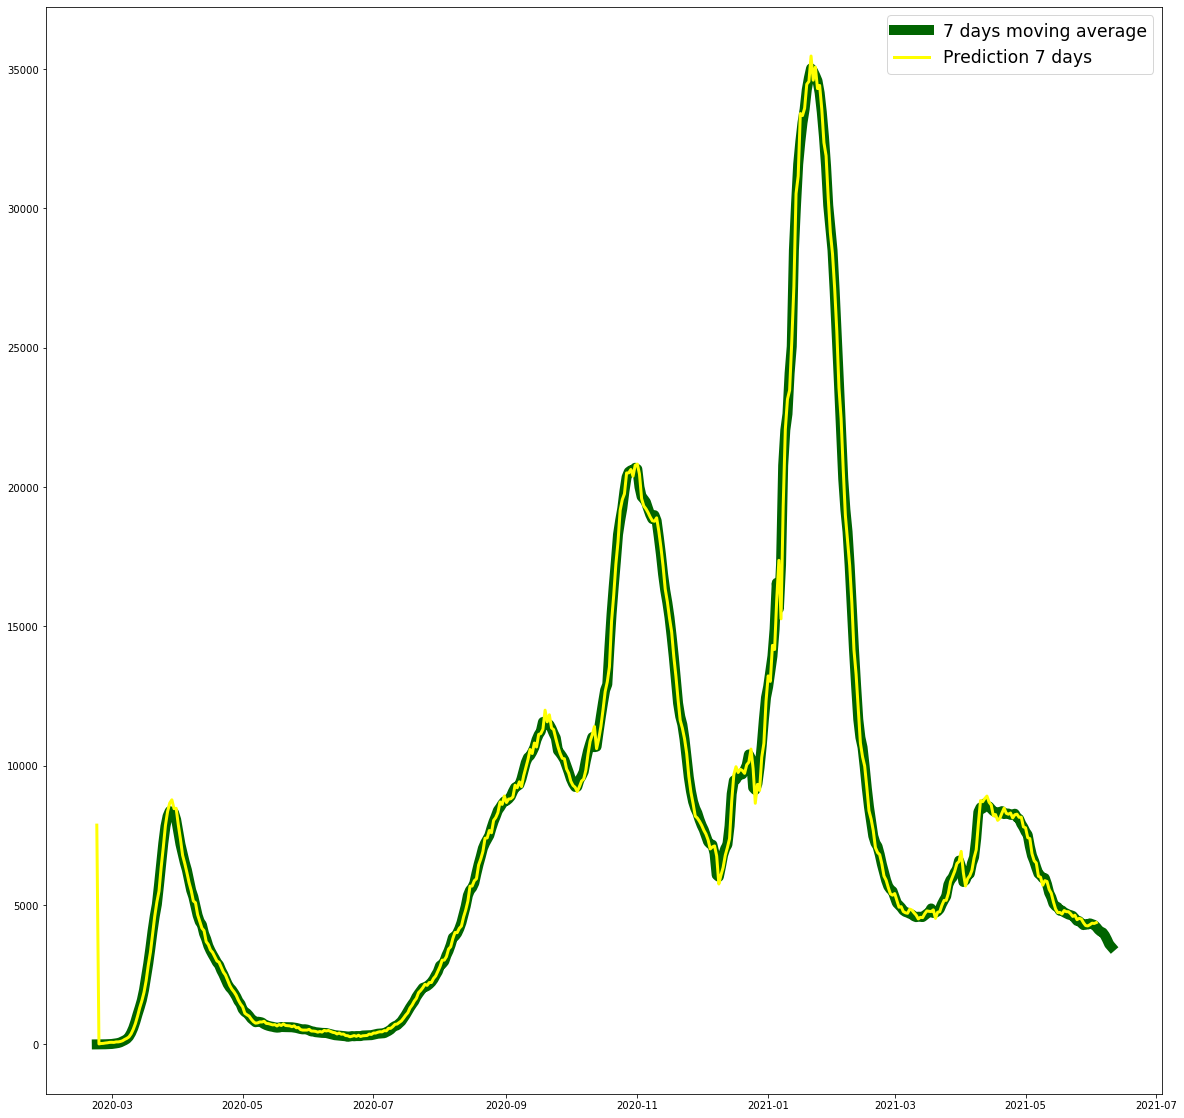

In [85]:
compare_pred(pred_num_infections_7)

# Number of hospitalisation

In [26]:
hosp = bydate[['date', 'ave_7_num_hosp']].set_index('date')
hosp = hosp[6:]
train, test = hosp[:-1], hosp[-1:]

In [27]:
model=ARMA(train, order = (2, 2)).fit(disp=False)

In [29]:
mse(model.predict(len(train), len(hosp)-1), test)**0.5

0.4924252030553191

In [31]:
pred_num_hosp_1 = predict('Number of hospitalisation', 1)

rsme: 0.4924252030553191 daily hospitalisations


In [32]:
pred_num_hosp_3 = predict('Number of hospitalisation', 3)

rsme: 17.309328742227592 daily hospitalisations


In [33]:
pred_num_hosp_5 = predict('Number of hospitalisation', 5)

rsme: 23.474666310864254 daily hospitalisations


In [34]:
pred_num_hosp_7 = predict('Number of hospitalisation', 7)

rsme: 17.752726136805787 daily hospitalisations


# Number of Intensive Care Units

In [37]:
pred_num_uci_1 = predict('Number of Intensive Care Unit', 1)

rsme: 1.890054432097731 daily intensive care unit


In [38]:
pred_num_uci_3 = predict('Number of Intensive Care Unit', 3)

rsme: 0.5479489411117608 daily intensive care unit


In [39]:
pred_num_uci_5 = predict('Number of Intensive Care Unit', 5)

rsme: 5.567187425260014 daily intensive care unit


In [40]:
pred_num_uci_7 = predict('Number of Intensive Care Unit', 7)

rsme: 6.43941312604807 daily intensive care unit


# Number of deaths

In [41]:
pred_num_dead_1 = predict('Number of deaths', 1)

rsme: 0.20906624231148285 daily deaths


In [42]:
pred_num_dead_3 = predict('Number of deaths', 3)

rsme: 0.30310804371875627 daily deaths


In [43]:
pred_num_dead_5 = predict('Number of deaths', 5)

rsme: 3.6016905827662167 daily deaths


In [44]:
pred_num_dead_7 = predict('Number of deaths', 7)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.
rsme: 9.564724436904507 daily deaths
